# Prediction of KChip interactions using mono-culture and CommScores features

In [1]:
import pathlib

import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
interaction_folder = pathlib.Path("../../data/raw/kchip/interactions")

In [4]:
# labels extracted from heatmap image
row_labels = [ "PAl", "PAg2", "PAg1", "PAg3", "LA", "EL", "RP2", "RP1", "SF", "BI", "KA", "CF", "EC", "EA", "PK", "PR1", "PAr", "PR2", "PH", "PP", ]
# ignore the diluted media conditions
column_labels = [
    "Glycerol", "Glutamine", "Cellobiose", "Rhamnose", "Maltose", "Mannose", "GlcNAc", "Trehalose", "Glucose", "Mix", "Pyruvate", "Alanine",
    "Fructose", "Galactose", "Ribose", "Xylose", "Mannitol", "L-Arabinose", "Sorbitol", "Lactose", "Sucrose", "Raffinose", "Uridine", "Arabinogalactan",
    "Melezitose", "Water", "D-Arabinose", "Serine", "Isoleucine", "Arginine", "Acetate", "Citrate", "Fumarate", "Succinate", "Proline",
]

## Interaction data visualization

In [5]:
interaction_file = interaction_folder / "interactions.csv"
raw_interaction_df = pd.read_csv(interaction_file)
raw_interaction_df

,Bug 1,Bug 2,Carbon,1 on 2: Effect,1 on 2: 25th Percentile,1 on 2: 75th Percentile,1 on 2: Replicates,2 on 1: Effect,2 on 1: 25th Percentile,2 on 1: 75th Percentile,2 on 1: Replicates,Class,Type,Strength
0,PAl,PAl,ArabinoseD,0.000000,0.000000,0.000000,5,0.0,0.0,0.000000,5,Neutralism,NaN,0.000000
1,PAl,PAg2,ArabinoseD,0.392474,-0.063408,0.945052,9,0.0,0.0,0.000000,6,Neutralism,45.0,0.392474
2,PAl,PAg1,ArabinoseD,NaN,NaN,NaN,1,0.0,0.0,0.120721,6,Inconclusive,NaN,NaN
3,PAl,PAg3,ArabinoseD,0.000000,0.000000,0.000000,6,0.0,0.0,0.000000,8,Neutralism,NaN,0.000000
4,PAl,LA,ArabinoseD,0.806290,0.384895,1.164122,6,0.0,0.0,0.000000,5,Commensalism,45.0,0.806290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,PP,PR1,Water,0.000000,0.000000,0.000000,5,0.0,0.0,0.000000,16,Neutralism,NaN,0.000000
15996,PP,PAr,Water,0.000000,0.000000,0.000000,10,0.0,0.0,0.000000,8,Neutralism,NaN,0.000000
15997,PP,PR2,Water,0.000000,0.000000,0.000000,10,0.0,0.0,0.000000,12,Neutralism,NaN,0.000000
15998,PP,PH,Water,0.000000,0.000000,0.000000,13,0.0,0.0,0.000000,8,Neutralism,NaN,0.000000


In [6]:
interaction_df = raw_interaction_df.copy()
# Rename Carbon sources (ArabinoseD -> D-Arabinose)
interaction_df["Carbon"] = raw_interaction_df["Carbon"].replace(
    {"ArabinoseD": "D-Arabinose", "ArabinoseL": "L-Arabinose"}
)
interaction_df["Bug 1"] = interaction_df["Bug 1"].replace({"SF1": "SF"})
interaction_df["Bug 2"] = interaction_df["Bug 2"].replace({"SF2": "SF"})
# Drop rows and columns that are not in the labels
interaction_df = interaction_df[interaction_df["Carbon"].isin(column_labels)]
interaction_df = interaction_df[interaction_df["Bug 1"].isin(row_labels)]
interaction_df = interaction_df[interaction_df["Bug 2"].isin(row_labels)]
# QUESTION: Should we drop the self-interactions?
interaction_df = interaction_df[interaction_df["Bug 1"] != interaction_df["Bug 2"]]
interaction_df

,Bug 1,Bug 2,Carbon,1 on 2: Effect,1 on 2: 25th Percentile,1 on 2: 75th Percentile,1 on 2: Replicates,2 on 1: Effect,2 on 1: 25th Percentile,2 on 1: 75th Percentile,2 on 1: Replicates,Class,Type,Strength
1,PAl,PAg2,D-Arabinose,0.392474,-0.063408,0.945052,9,0.0,0.0,0.000000,6,Neutralism,45.0,0.392474
2,PAl,PAg1,D-Arabinose,NaN,NaN,NaN,1,0.0,0.0,0.120721,6,Inconclusive,NaN,NaN
3,PAl,PAg3,D-Arabinose,0.000000,0.000000,0.000000,6,0.0,0.0,0.000000,8,Neutralism,NaN,0.000000
4,PAl,LA,D-Arabinose,0.806290,0.384895,1.164122,6,0.0,0.0,0.000000,5,Commensalism,45.0,0.806290
5,PAl,EL,D-Arabinose,0.000000,0.000000,0.407752,10,0.0,0.0,0.000000,8,Neutralism,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15994,PP,PK,Water,0.000000,0.000000,0.000000,22,0.0,0.0,0.000000,17,Neutralism,NaN,0.000000
15995,PP,PR1,Water,0.000000,0.000000,0.000000,5,0.0,0.0,0.000000,16,Neutralism,NaN,0.000000
15996,PP,PAr,Water,0.000000,0.000000,0.000000,10,0.0,0.0,0.000000,8,Neutralism,NaN,0.000000
15997,PP,PR2,Water,0.000000,0.000000,0.000000,10,0.0,0.0,0.000000,12,Neutralism,NaN,0.000000


<Axes: xlabel='Class'>

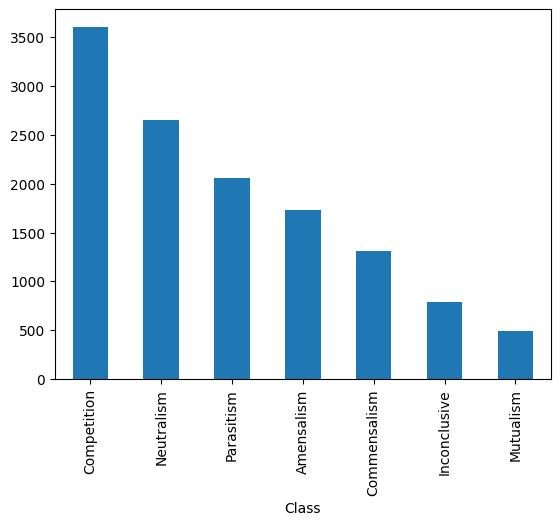

In [7]:
# get count of each Class in interaction_df
interaction_df.Class.value_counts().plot(kind="bar")

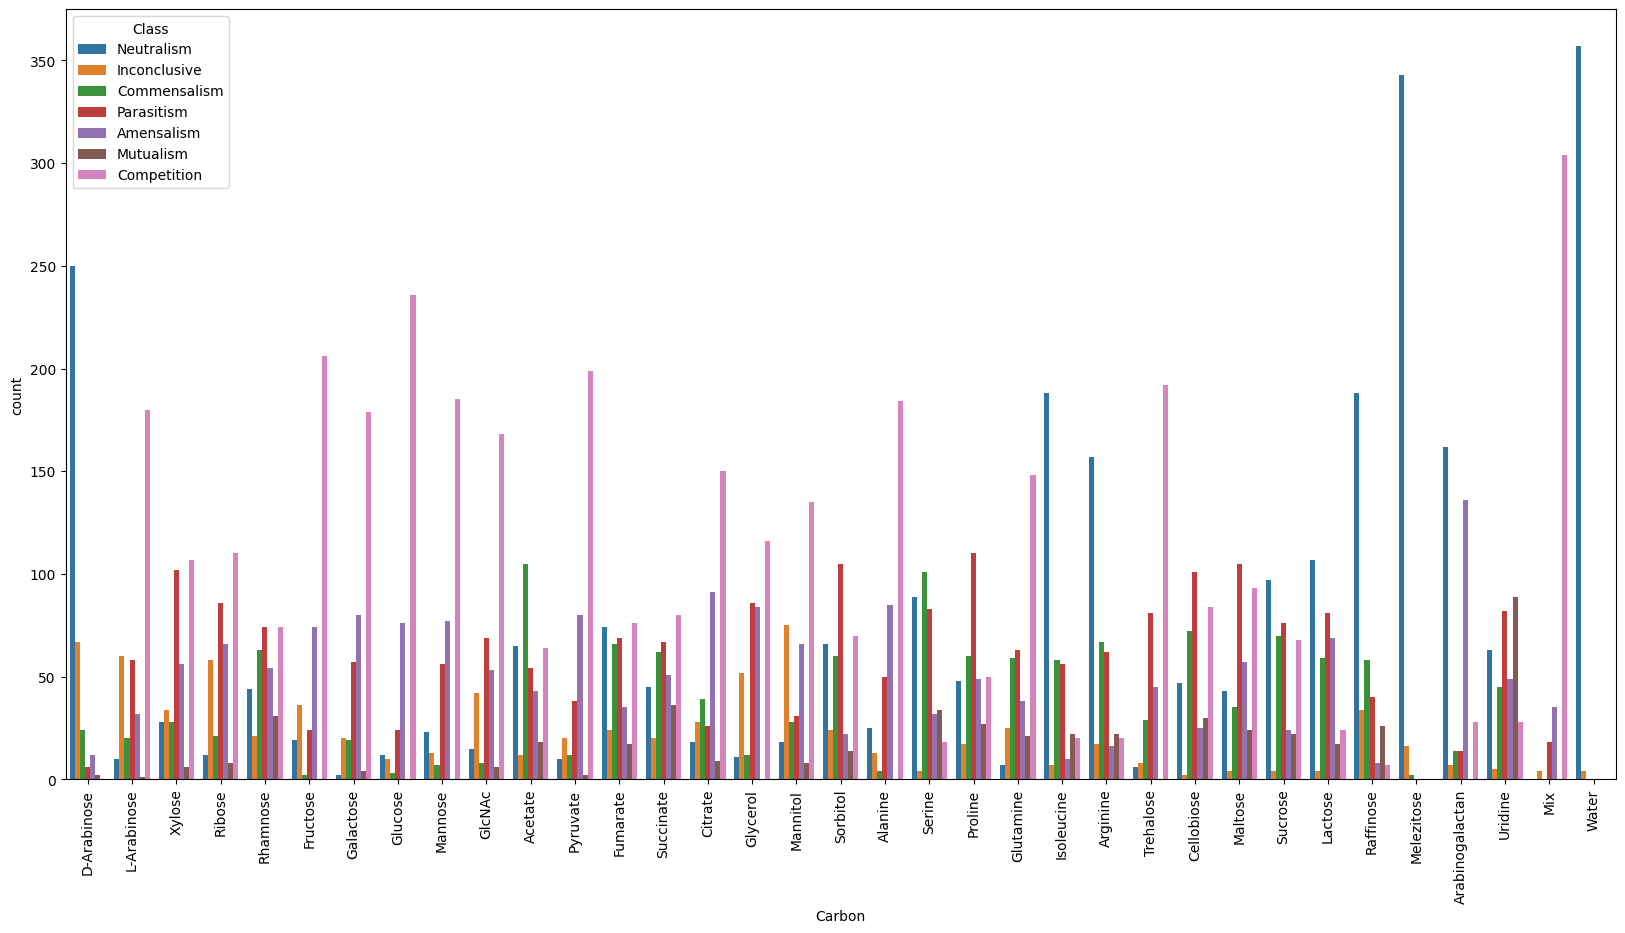

In [8]:
plt.figure(figsize=(20, 10))
sns.countplot(x="Carbon", data=interaction_df, hue="Class")
plt.xticks(rotation=90)

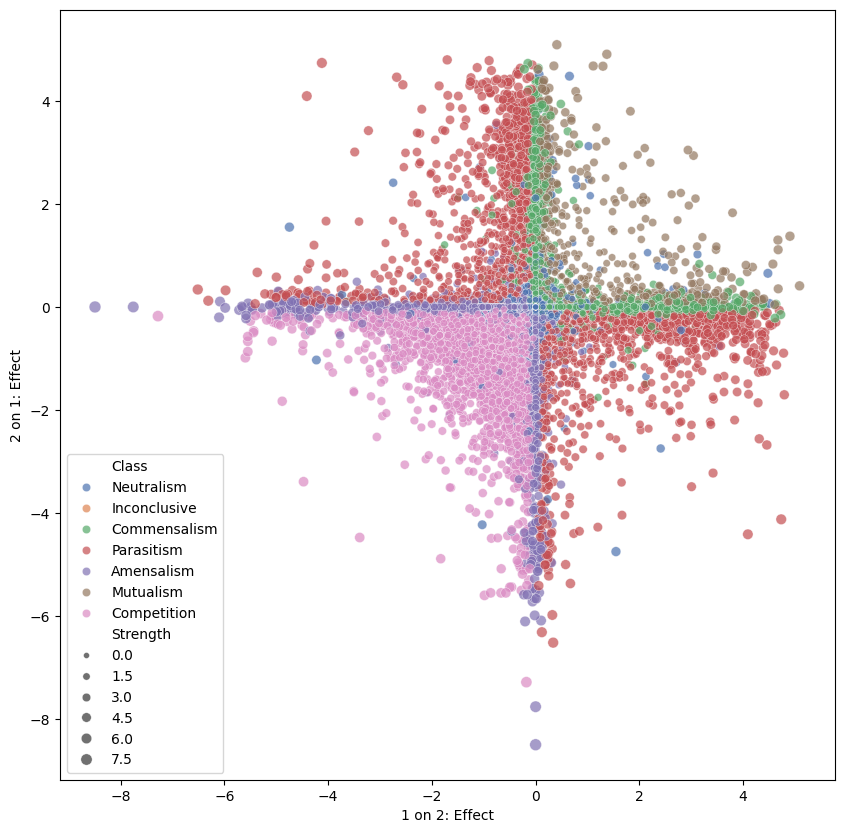

In [72]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x="1 on 2: Effect",
    y="2 on 1: Effect",
    data=interaction_df,
    hue="Class",
    alpha=0.7,
    size="Strength",
    palette="deep",
);

## Feature preparation

Features to use:
- experimental yield (bug 1 and bug 2)
- growth rates from FBA (bug 1 and bug 2)
- number of media conditions they both grow in (experimental & predicted)
- number of media conditions they both don't grow in (experimental & predicted)
- number of media conditions one grows in and the other doesn't (experimental & predicted)

Labels to use:
1. interaction classes (competition, mutualism, amensalism, commensalism, neutralism, parasitism, inconclusive)
2. interaction type (positive, negative, neutral)
3. interaction strength (regression)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Monoculture growth features

In [11]:
# read monoculture data
data_folder = pathlib.Path("../../data/processed/kchip/")
monoculture_file = data_folder / "monoculture_yield_growth.csv"

In [12]:
monoculture_df = pd.read_csv(monoculture_file)
monoculture_df

,index,carbon,exp_yield,pred_growth
0,BI,D-Arabinose,-6.838340,0.410242
1,CF,D-Arabinose,-1.925922,0.410242
2,EA,D-Arabinose,-6.523152,0.000000
3,EC,D-Arabinose,13.082301,0.000000
4,EL,D-Arabinose,4.188936,0.716811
...,...,...,...,...
695,PR1,Water,0.000000,0.000000
696,PR2,Water,0.000000,0.000000
697,RP1,Water,0.000000,0.410067
698,RP2,Water,0.000000,0.249062


<Axes: >

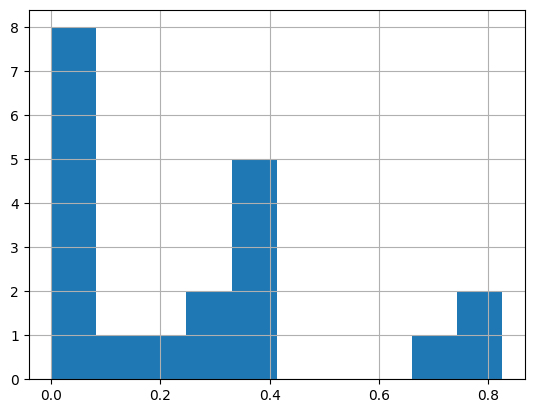

In [13]:
monoculture_df[monoculture_df.carbon == "Water"].pred_growth.hist()

### CommScores features

In [130]:
from sklearn.preprocessing import LabelEncoder

In [133]:
commscores_folder = data_folder / "commscores"
commscores_files = commscores_folder.glob("*.csv")
raw_commscores = pd.concat([pd.read_csv(f) for f in commscores_files]).drop_duplicates(subset=["media", "model1", "model2"])
raw_commscores = raw_commscores[raw_commscores.model1 != raw_commscores.model2]
label_encoder = LabelEncoder()
raw_commscores["BIT"] = label_encoder.fit_transform(raw_commscores.BIT)
raw_commscores

,model1,model2,media,monoculture growth model1,monoculture growth model2,coculture growth model1,coculture growth model2,community growth,MRO_model1,MRO_model2,...,MIP_model1 (costless),MIP_model2 (costless),BSS_model1,BSS_model2,PC_model1,PC_model2,PC_comm,BIT,GYD1,GYD2
0,PK.genome.mdl,PAg2.genome.mdl,M9_Alanine,5.1835,6.3772,11.262574,0.466426,11.729,62.500% (20/32),76.923% (20/26),...,0 (0),0 (0),57.692%,62.5%,2.17280,0.07314,1.01460,5,-0.230290,0.187180
1,PK.genome.mdl,PAg2.genome.mdl,M9_Arginine,13.8110,15.9920,22.415109,3.554891,25.970,62.500% (20/32),76.923% (20/26),...,4 (0),1 (0),57.692%,62.5%,1.62300,0.22229,0.87139,5,-0.157920,0.136380
2,PK.genome.mdl,PAg2.genome.mdl,M9_Fructose,30.9640,38.0110,42.567212,13.656788,56.224,62.500% (20/32),76.923% (20/26),...,0 (0),0 (0),57.692%,62.5%,1.37470,0.35929,0.81514,5,-0.227590,0.185390
3,PK.genome.mdl,PAg2.genome.mdl,M9_GlcNAc,30.0810,37.1350,49.170783,12.994217,62.165,62.500% (20/32),76.923% (20/26),...,0 (0),0 (0),57.692%,62.5%,1.63460,0.34992,0.92485,5,-0.234500,0.189960
4,PK.genome.mdl,PAg2.genome.mdl,M9_Acetate,7.6402,14.9950,21.383336,4.454664,25.838,62.500% (20/32),76.923% (20/26),...,0 (0),0 (0),57.692%,62.5%,2.79880,0.29708,1.14150,5,-0.962640,0.490480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5498,SF.genome.mdl,BI.genome.mdl,M9_Rhamnose,36.3190,29.7430,44.082178,5.730822,49.813,82.609% (19/23),82.609% (19/23),...,2 (0),0 (0),60.87%,60.87%,1.21370,0.19268,0.75403,5,0.181060,-0.221090
5499,SF.genome.mdl,BI.genome.mdl,M9_Sorbitol,36.3820,31.4000,35.042270,5.052730,40.095,82.609% (19/23),82.609% (19/23),...,0 (0),0 (0),60.87%,60.87%,0.96318,0.16091,0.59153,0,0.136940,-0.158660
5500,SF.genome.mdl,BI.genome.mdl,M9_Succinate,32.5560,32.5750,39.256580,4.470420,43.727,82.609% (19/23),82.609% (19/23),...,1 (0),0 (0),60.87%,60.87%,1.20580,0.13723,0.67137,5,-0.000584,0.000583
5501,SF.genome.mdl,BI.genome.mdl,M9_Trehalose,60.5730,51.6370,70.404347,9.881653,80.286,82.609% (19/23),82.609% (19/23),...,0 (0),0 (0),60.87%,60.87%,1.16230,0.19137,0.71550,5,0.147520,-0.173050


In [134]:
def parse_commscores(row):
    return pd.Series(
        {
            "model1": row["model1"].removesuffix(".genome.mdl"),
            "model2": row["model2"].removesuffix(".genome.mdl"),
            "media": row["media"].removeprefix("M9_"),
            "monogr_model1": row["monoculture growth model1"],
            "monogr_model2": row["monoculture growth model2"],
            "cogr_model1": row["coculture growth model1"],
            "cogr_model2": row["coculture growth model2"],
            "comm_growth": row["community growth"],
            "mro_model1": float(row["MRO_model1"].split("%")[0]),
            "mro_model2": float(row["MRO_model2"].split("%")[0]),
            "cip": row["CIP"],
            "mip_model1": int(row["MIP_model1 (costless)"].split(" ")[0]),
            "mip_model2": int(row["MIP_model2 (costless)"].split(" ")[0]),
            "cmip_model1": int(row["MIP_model1 (costless)"].split(" ")[-1].strip("()")),
            "cmip_model2": int(row["MIP_model2 (costless)"].split(" ")[-1].strip("()")),
            "bss_model1": float(row["BSS_model1"].strip("%")),
            "bss_model2": float(row["BSS_model2"].strip("%")),
            "pc_model1": row["PC_model1"],
            "pc_model2": row["PC_model2"],
            "pc_comm": row["PC_comm"],
            "bit": row["BIT"],
            "gyd_model1": row["GYD1"],
            "gyd_model2": row["GYD2"],
        }
    )

In [135]:
commscores = raw_commscores.apply(parse_commscores, axis=1, result_type="expand").drop_duplicates(subset=["media", "model1", "model2"])
commscores

,model1,model2,media,monogr_model1,monogr_model2,cogr_model1,cogr_model2,comm_growth,mro_model1,mro_model2,...,cmip_model1,cmip_model2,bss_model1,bss_model2,pc_model1,pc_model2,pc_comm,bit,gyd_model1,gyd_model2
0,PK,PAg2,Alanine,5.1835,6.3772,11.262574,0.466426,11.729,62.500,76.923,...,0,0,57.692,62.50,2.17280,0.07314,1.01460,5,-0.230290,0.187180
1,PK,PAg2,Arginine,13.8110,15.9920,22.415109,3.554891,25.970,62.500,76.923,...,0,0,57.692,62.50,1.62300,0.22229,0.87139,5,-0.157920,0.136380
2,PK,PAg2,Fructose,30.9640,38.0110,42.567212,13.656788,56.224,62.500,76.923,...,0,0,57.692,62.50,1.37470,0.35929,0.81514,5,-0.227590,0.185390
3,PK,PAg2,GlcNAc,30.0810,37.1350,49.170783,12.994217,62.165,62.500,76.923,...,0,0,57.692,62.50,1.63460,0.34992,0.92485,5,-0.234500,0.189960
4,PK,PAg2,Acetate,7.6402,14.9950,21.383336,4.454664,25.838,62.500,76.923,...,0,0,57.692,62.50,2.79880,0.29708,1.14150,5,-0.962640,0.490480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5498,SF,BI,Rhamnose,36.3190,29.7430,44.082178,5.730822,49.813,82.609,82.609,...,0,0,60.870,60.87,1.21370,0.19268,0.75403,5,0.181060,-0.221090
5499,SF,BI,Sorbitol,36.3820,31.4000,35.042270,5.052730,40.095,82.609,82.609,...,0,0,60.870,60.87,0.96318,0.16091,0.59153,0,0.136940,-0.158660
5500,SF,BI,Succinate,32.5560,32.5750,39.256580,4.470420,43.727,82.609,82.609,...,0,0,60.870,60.87,1.20580,0.13723,0.67137,5,-0.000584,0.000583
5501,SF,BI,Trehalose,60.5730,51.6370,70.404347,9.881653,80.286,82.609,82.609,...,0,0,60.870,60.87,1.16230,0.19137,0.71550,5,0.147520,-0.173050


#### Verify that the CommScores growth predictions are correct

In [92]:
commscores_gr = (
    commscores.groupby(["model1", "media"])["monogr_model1"].mean().reset_index()
)

<Axes: xlabel='monogr_model1', ylabel='pred_growth'>

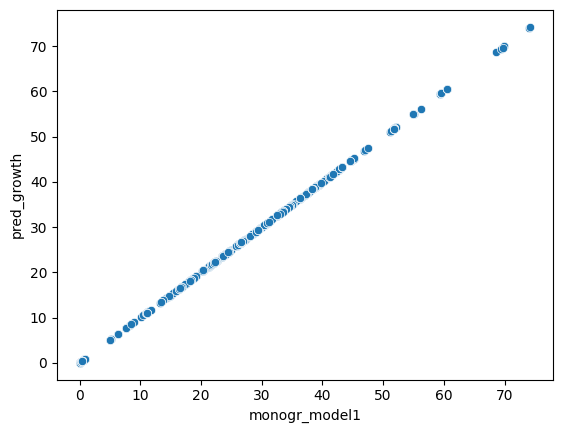

In [95]:
comm_gr_comp = commscores_gr.merge(
    monoculture_df, left_on=["model1", "media"], right_on=["index", "carbon"]
)
sns.scatterplot(x="monogr_model1", y="pred_growth", data=comm_gr_comp)

## Machine learning using mono-culture features

### Creating the feature matrices

In [20]:
monoculture_yield_matrix = monoculture_df.pivot(
    index="index", columns="carbon", values="exp_yield"
)
monoculture_yield_norm = monoculture_yield_matrix.apply(lambda x: x / x.max(), axis=1)
monoculture_yield_norm[monoculture_yield_norm < 0.2] = 0
monoculture_growth_matrix = monoculture_df.pivot(
    index="index", columns="carbon", values="pred_growth"
)
monoculture_growth_norm = monoculture_growth_matrix.apply(lambda x: x / x.max(), axis=1)
monoculture_growth_norm[monoculture_growth_norm < 0.1] = 0

In [21]:
interaction_df_labels = interaction_df[
    ["Bug 1", "Bug 2", "Carbon", "Class", "2 on 1: Effect"]
].rename(
    columns={
        "Bug 1": "bug1",
        "Bug 2": "bug2",
        "Carbon": "carbon",
        "Class": "class",
        "2 on 1: Effect": "effect_2on1",
    }
)
interaction_df_labels

,bug1,bug2,carbon,class,effect_2on1
1,PAl,PAg2,D-Arabinose,Neutralism,0.0
2,PAl,PAg1,D-Arabinose,Inconclusive,0.0
3,PAl,PAg3,D-Arabinose,Neutralism,0.0
4,PAl,LA,D-Arabinose,Commensalism,0.0
5,PAl,EL,D-Arabinose,Neutralism,0.0
...,...,...,...,...,...
15994,PP,PK,Water,Neutralism,0.0
15995,PP,PR1,Water,Neutralism,0.0
15996,PP,PAr,Water,Neutralism,0.0
15997,PP,PR2,Water,Neutralism,0.0


In [22]:
feature_data = []
all_carbon_sources = set(monoculture_yield_matrix.columns)
for index, row in interaction_df_labels.iterrows():
    bug1 = row["bug1"]
    bug2 = row["bug2"]
    carbon = row["carbon"]
    bug1_yield = monoculture_yield_matrix.loc[bug1, carbon]
    bug2_yield = monoculture_yield_matrix.loc[bug2, carbon]
    bug1_bin_yield = monoculture_yield_norm.loc[bug1, carbon] > 0
    bug2_bin_yield = monoculture_yield_norm.loc[bug2, carbon] > 0
    bug1_growth = monoculture_growth_matrix.loc[bug1, carbon]
    bug2_growth = monoculture_growth_matrix.loc[bug2, carbon]
    bug1_bin_growth = monoculture_growth_norm.loc[bug1, carbon] > 0
    bug2_bin_growth = monoculture_growth_norm.loc[bug2, carbon] > 0
    bug1_yield_media = set(
        monoculture_yield_norm.columns[monoculture_yield_norm.loc[bug1] > 0]
    )
    bug2_yield_media = set(
        monoculture_yield_norm.columns[monoculture_yield_norm.loc[bug2] > 0]
    )
    bug1_growth_media = set(
        monoculture_growth_norm.columns[monoculture_growth_norm.loc[bug1] > 0]
    )
    bug2_growth_media = set(
        monoculture_growth_norm.columns[monoculture_growth_norm.loc[bug2] > 0]
    )
    # number of carbon sources in which both bugs have positive yield
    pos_yield = len(bug1_yield_media.intersection(bug2_yield_media))
    pos_growth = len(bug1_growth_media.intersection(bug2_growth_media))
    # number of carbon sources in which both bugs have zero yield
    neg_yield = len(
        all_carbon_sources.difference(bug1_yield_media.union(bug2_yield_media))
    )
    neg_growth = len(
        all_carbon_sources.difference(bug1_growth_media.union(bug2_growth_media))
    )
    # number of carbon sources in which one bug has positive yield and the other has zero yield
    bug1_adv_yield = bug1_yield_media.difference(bug2_yield_media)
    bug2_adv_yield = bug2_yield_media.difference(bug1_yield_media)
    bug1_adv_growth = bug1_growth_media.difference(bug2_growth_media)
    bug2_adv_growth = bug2_growth_media.difference(bug1_growth_media)
    feature_data.append(
        {
            "bug1": bug1,
            "bug2": bug2,
            "carbon": carbon,
            "class": row["class"],
            "effect_2on1": row["effect_2on1"],
            "bug1_yield": bug1_yield,
            "bug1_bin_yield": bug1_bin_yield,
            "bug2_bin_yield": bug2_bin_yield,
            "bug2_yield": bug2_yield,
            "1by2_yield": (
                np.abs(bug1_yield / bug2_yield) if bug2_yield > 0 else 100_000
            ),
            "bug1_growth": bug1_growth,
            "bug2_growth": bug2_growth,
            "bug1_bin_growth": bug1_bin_growth,
            "bug2_bin_growth": bug2_bin_growth,
            "1by2_growth": (
                np.abs(bug1_growth / bug2_growth) if bug2_growth > 0 else 1_000
            ),
            "pos_yield": pos_yield,
            "neg_yield": neg_yield,
            "pos_growth": pos_growth,
            "neg_growth": neg_growth,
            "bug1_adv_yield": len(bug1_adv_yield),
            "bug2_adv_yield": len(bug2_adv_yield),
            "bug1_adv_growth": len(bug1_adv_growth),
            "bug2_adv_growth": len(bug2_adv_growth),
        }
    )
feature_matrix = pd.DataFrame(feature_data)

In [23]:
# drop rows with NaN values in effect_2on1 column
feature_matrix = feature_matrix.dropna(subset=["effect_2on1"])
feature_matrix

,bug1,bug2,carbon,class,effect_2on1,bug1_yield,bug1_bin_yield,bug2_bin_yield,bug2_yield,1by2_yield,...,bug2_bin_growth,1by2_growth,pos_yield,neg_yield,pos_growth,neg_growth,bug1_adv_yield,bug2_adv_yield,bug1_adv_growth,bug2_adv_growth
0,PAl,PAg2,D-Arabinose,Neutralism,0.0,-1.375435,False,False,126.978597,0.010832,...,False,3.666112,17,11,24,8,4,3,2,1
1,PAl,PAg1,D-Arabinose,Inconclusive,0.0,-1.375435,False,False,0.996728,1.379950,...,False,0.998757,19,10,24,8,2,4,2,1
2,PAl,PAg3,D-Arabinose,Neutralism,0.0,-1.375435,False,False,4.516501,0.304535,...,False,1000.000000,17,10,23,8,4,4,3,1
3,PAl,LA,D-Arabinose,Commensalism,0.0,-1.375435,False,False,5.215996,0.263695,...,False,3.310839,16,9,24,7,5,5,2,2
4,PAl,EL,D-Arabinose,Neutralism,0.0,-1.375435,False,False,4.188936,0.328349,...,False,1.150300,20,8,25,7,1,6,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12630,PP,PK,Water,Neutralism,0.0,0.000000,False,False,0.000000,100000.000000,...,False,0.000000,12,14,17,15,2,7,1,2
12631,PP,PR1,Water,Neutralism,0.0,0.000000,False,False,0.000000,100000.000000,...,False,1000.000000,14,13,18,12,0,8,0,5
12632,PP,PAr,Water,Neutralism,0.0,0.000000,False,False,0.000000,100000.000000,...,False,1000.000000,14,14,17,11,0,7,1,6
12633,PP,PR2,Water,Neutralism,0.0,0.000000,False,False,0.000000,100000.000000,...,False,1000.000000,13,16,17,13,1,5,1,4


In [24]:
feature_matrix.columns

Index(['bug1', 'bug2', 'carbon', 'class', 'effect_2on1', 'bug1_yield',
       'bug1_bin_yield', 'bug2_bin_yield', 'bug2_yield', '1by2_yield',
       'bug1_growth', 'bug2_growth', 'bug1_bin_growth', 'bug2_bin_growth',
       '1by2_growth', 'pos_yield', 'neg_yield', 'pos_growth', 'neg_growth',
       'bug1_adv_yield', 'bug2_adv_yield', 'bug1_adv_growth',
       'bug2_adv_growth'],
      dtype='object')

In [25]:
# effect_cutoff = interaction_df["2 on 1: Effect"][interaction_df.Class == "Neutralism"].abs()

In [26]:
def get_sign(row, effect_cutoff=0.1):
    effect = row["effect_2on1"]
    if np.abs(effect) < effect_cutoff:
        return "neutral"
    elif effect > 0:
        return "positive"
    else:
        return "negative"

In [27]:
y_sign = feature_matrix.apply(get_sign, axis=1)
y_strength = feature_matrix["effect_2on1"]
y_class = feature_matrix["class"]
yield_cols = [c for c in feature_matrix.columns if "yield" in c]
X_yield = feature_matrix[yield_cols]
growth_cols = [c for c in feature_matrix.columns if "growth" in c]
X_growth = feature_matrix[growth_cols]

### Creating training and plotting functions

In [190]:
def perform_cv(X, y, scoring, ctype="classification"):
    if ctype == "classification":
        model = RandomForestClassifier(n_estimators=300, max_depth=None, bootstrap=False, random_state=42)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv = cross_validate(model, X, y, cv=skf, scoring=scoring)
    elif ctype == "regression":
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        cv = cross_validate(model, X, y, cv=5, scoring=scoring)
    else:
        raise ValueError("Invalid ctype")
    df = pd.DataFrame(cv)
    test_cols = [col for col in df.columns if col.startswith("test_")]
    test_df = df[test_cols].rename(columns=lambda x: x.replace("test_", ""))
    return test_df

In [191]:
def perform_classification(X, y, ctype="classification"):
    if ctype == "classification":
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif ctype == "regression":
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    else:
        raise ValueError("Invalid ctype")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, y_test, y_pred

In [192]:
def plot_cv(Xyl_iter, scoring, ctype="classification"):
    cv_results_list = []
    for X, y, label in Xyl_iter:
        cv_results = perform_cv(X, y, scoring, ctype)
        cv_results["label"] = label
        cv_results_list.append(cv_results)
    test_combined = pd.concat(cv_results_list)
    plot_data = test_combined.melt(
        id_vars="label", var_name="metric", value_name="score"
    )
    sns.catplot(
        data=plot_data,
        x="metric",
        y="score",
        kind="strip",
        aspect=2,
        hue="label",
        jitter=0.2,
    )
    if ctype == "classification":
        plt.ylim(0, 1)

In [193]:
def plot_feature_importances(model, X, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [194]:
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    labels = np.unique(y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

### Predicting sign of interaction

Text(0.5, 0, 'Sign')

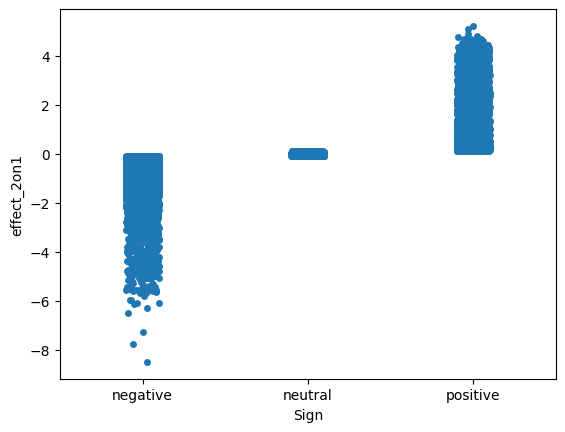

In [33]:
sns.stripplot(
    x=y_sign, y=feature_matrix["effect_2on1"], order=["negative", "neutral", "positive"]
)
plt.xlabel("Sign")

In [34]:
scoring = [
    "accuracy",
    "balanced_accuracy",
    "matthews_corrcoef",
    "precision_macro",
    "recall_macro",
    "f1_macro",
]

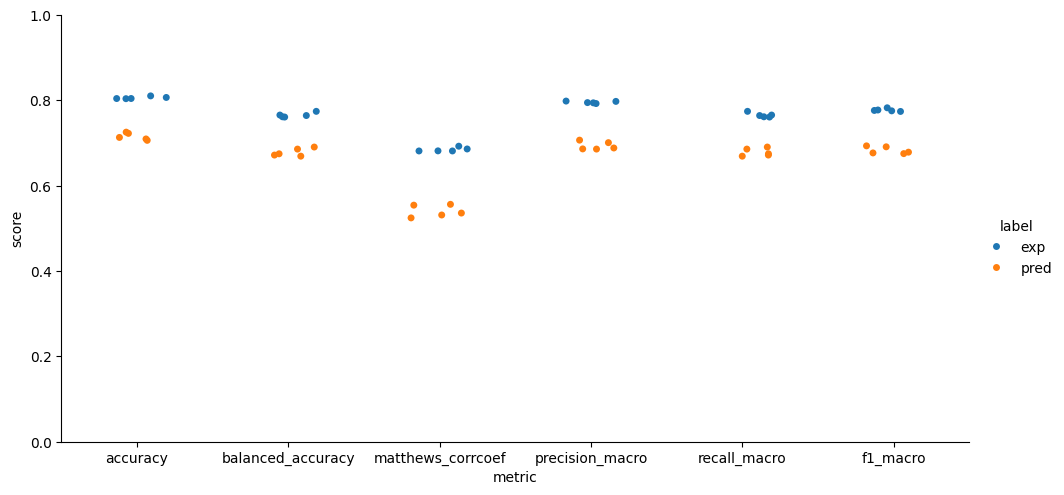

In [128]:
plot_cv([(X_yield, y_sign, "exp"), (X_growth, y_sign, "pred")], scoring)

In [36]:
model_sign_yield, y_test_sign_yield, y_pred_sign_yield = perform_classification(
    X_yield, y_sign
)
model_sign_growth, y_test_sign_growth, y_pred_sign_growth = perform_classification(
    X_growth, y_sign
)

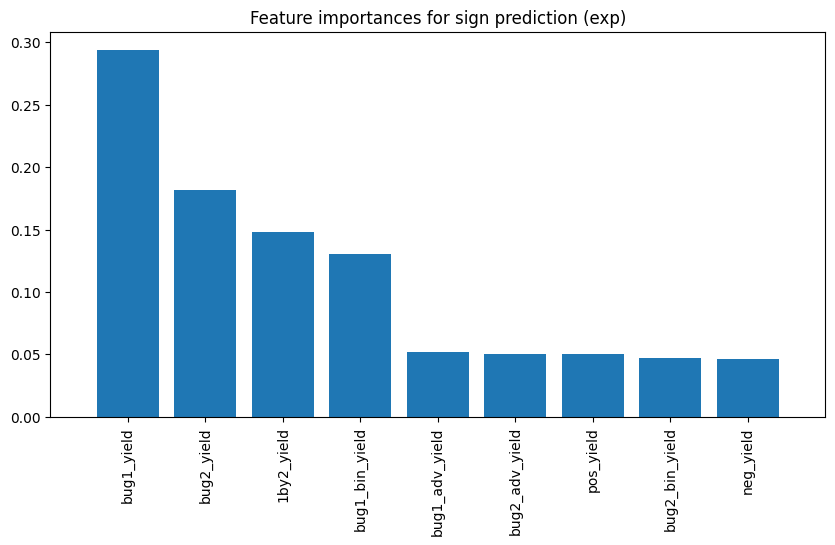

In [37]:
plot_feature_importances(
    model_sign_yield, X_yield, "Feature importances for sign prediction (exp)"
)

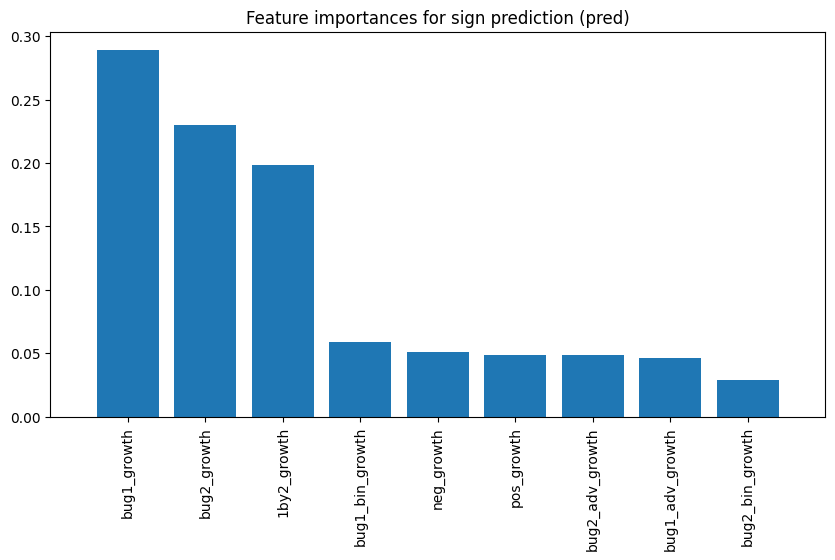

In [38]:
plot_feature_importances(
    model_sign_growth, X_growth, "Feature importances for sign prediction (pred)"
)

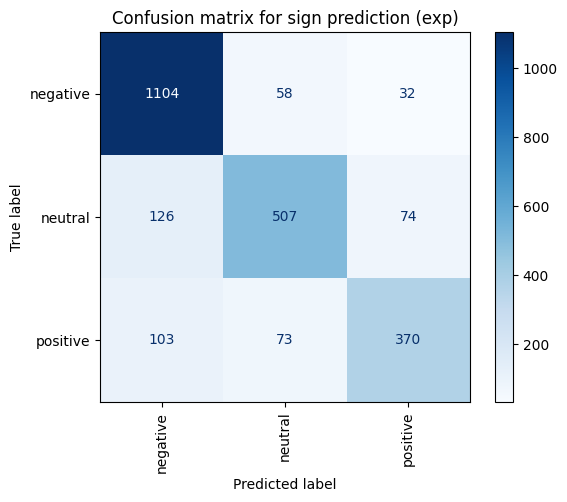

In [39]:
plot_confusion_matrix(
    y_test_sign_yield, y_pred_sign_yield, "Confusion matrix for sign prediction (exp)"
)

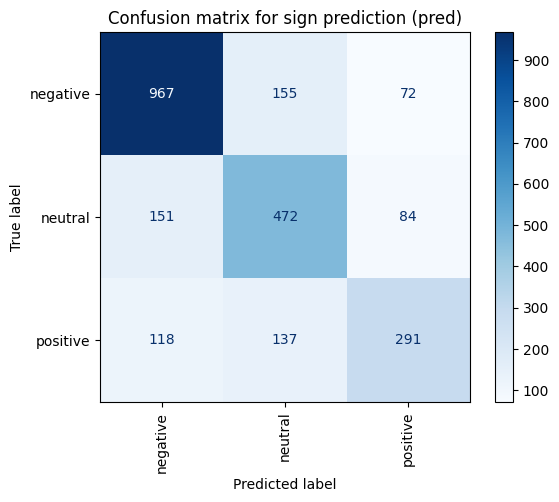

In [40]:
plot_confusion_matrix(
    y_test_sign_growth,
    y_pred_sign_growth,
    "Confusion matrix for sign prediction (pred)",
)

### Predicting interaction class

(-8.0, 8.0)

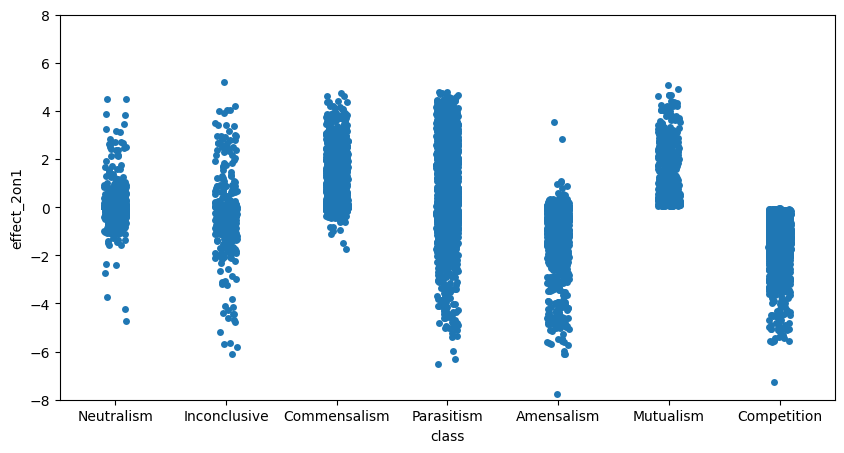

In [41]:
plt.figure(figsize=(10, 5))
sns.stripplot(x=y_class, y=feature_matrix["effect_2on1"])
plt.ylim(-8, 8)

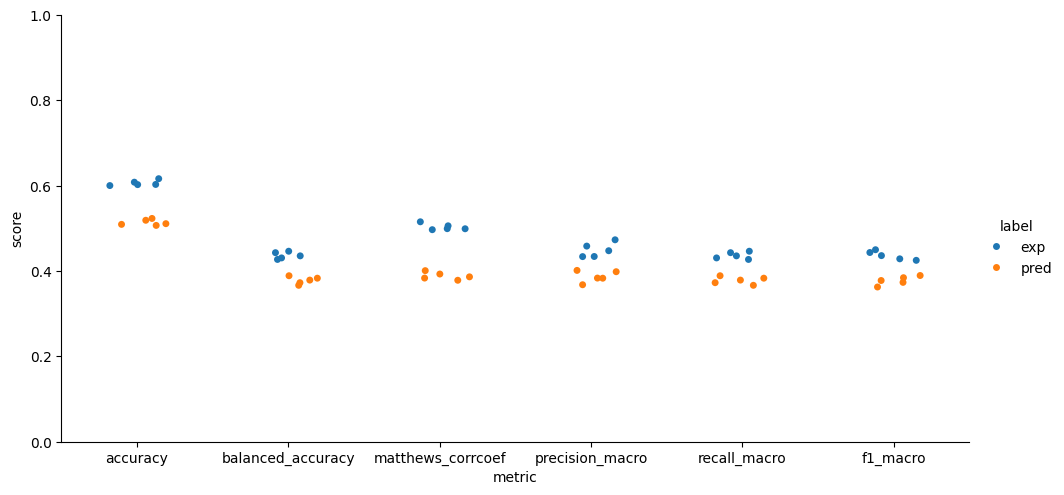

In [42]:
plot_cv(X_yield, X_growth, y_class, scoring)

In [43]:
model_class_yield, y_test_class_yield, y_pred_class_yield = perform_classification(
    X_yield, y_class
)
model_class_growth, y_test_class_growth, y_pred_class_growth = perform_classification(
    X_growth, y_class
)

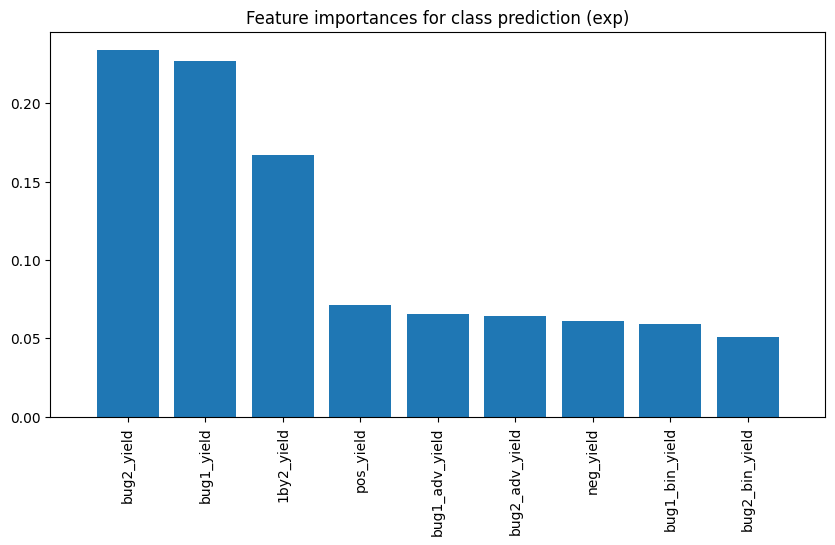

In [44]:
plot_feature_importances(
    model_class_yield, X_yield, "Feature importances for class prediction (exp)"
)

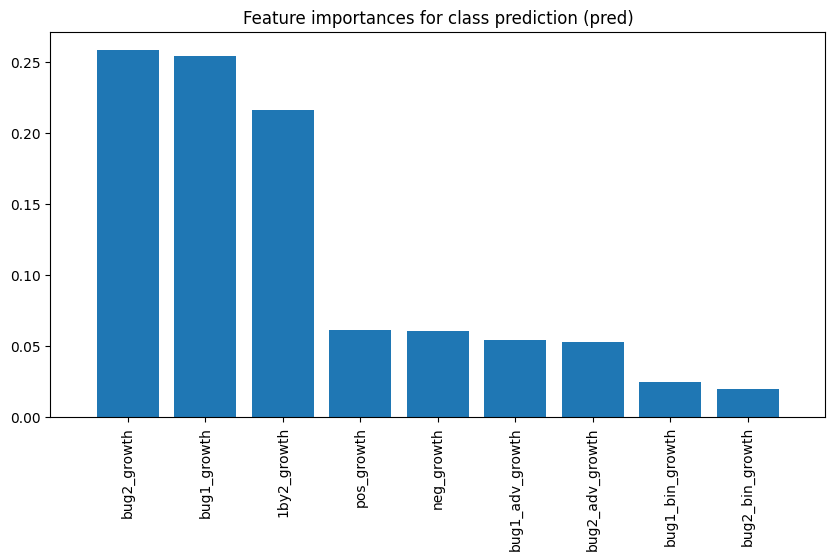

In [45]:
plot_feature_importances(
    model_class_growth, X_growth, "Feature importances for class prediction (pred)"
)

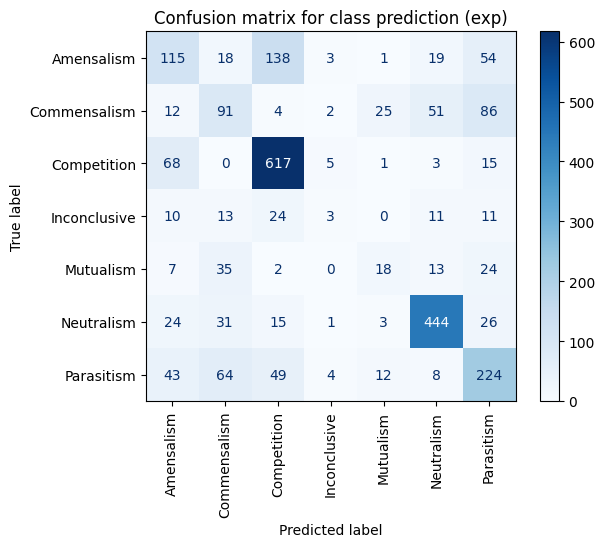

In [46]:
plot_confusion_matrix(
    y_test_class_yield,
    y_pred_class_yield,
    "Confusion matrix for class prediction (exp)",
)

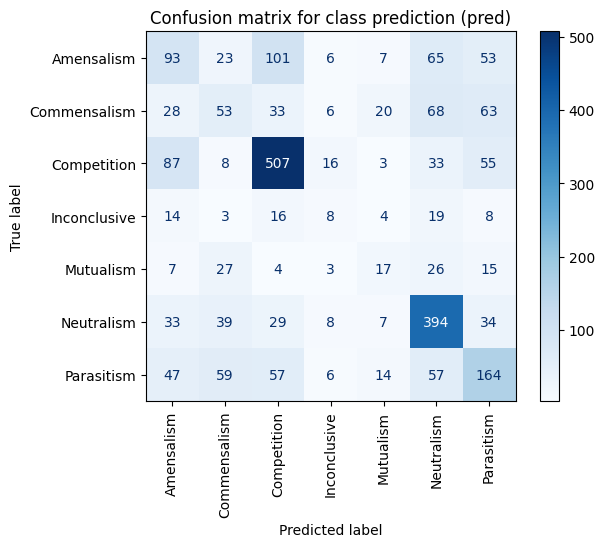

In [47]:
plot_confusion_matrix(
    y_test_class_growth,
    y_pred_class_growth,
    "Confusion matrix for class prediction (pred)",
)

### Strength prediction

(-8.0, 8.0)

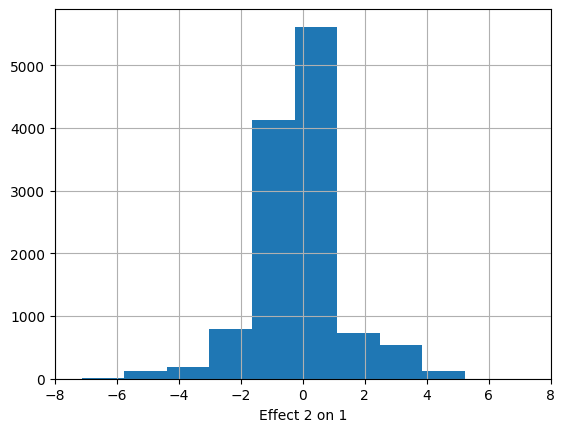

In [48]:
y_strength.hist()
plt.xlabel("Effect 2 on 1")
plt.xlim(-8, 8)

In [49]:
scoring = ["neg_mean_absolute_error", "neg_mean_squared_error", "r2"]

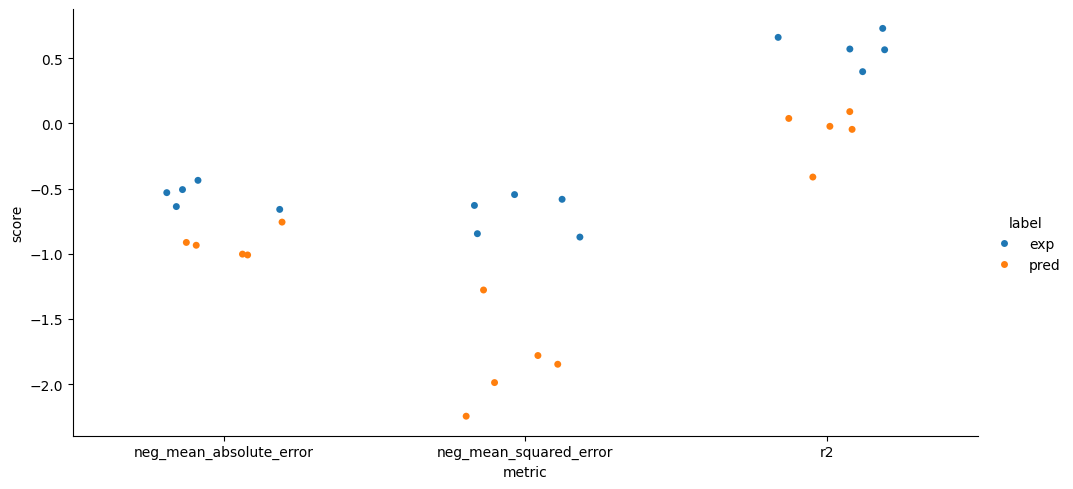

In [50]:
plot_cv(X_yield, X_growth, y_strength, scoring, ctype="regression")

In [51]:
model_strength_yield, y_test_strength_yield, y_pred_strength_yield = (
    perform_classification(X_yield, y_strength, ctype="regression")
)
model_strength_growth, y_test_strength_growth, y_pred_strength_growth = (
    perform_classification(X_growth, y_strength, ctype="regression")
)

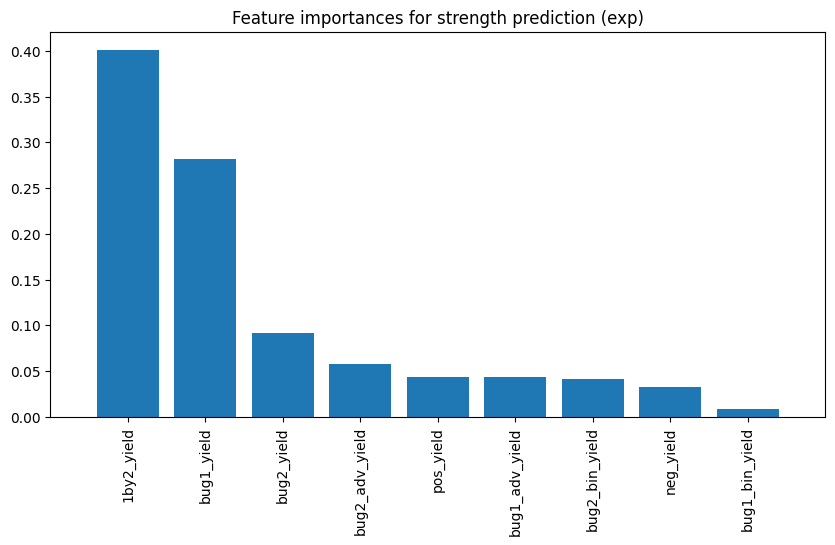

In [52]:
plot_feature_importances(
    model_strength_yield, X_yield, "Feature importances for strength prediction (exp)"
)

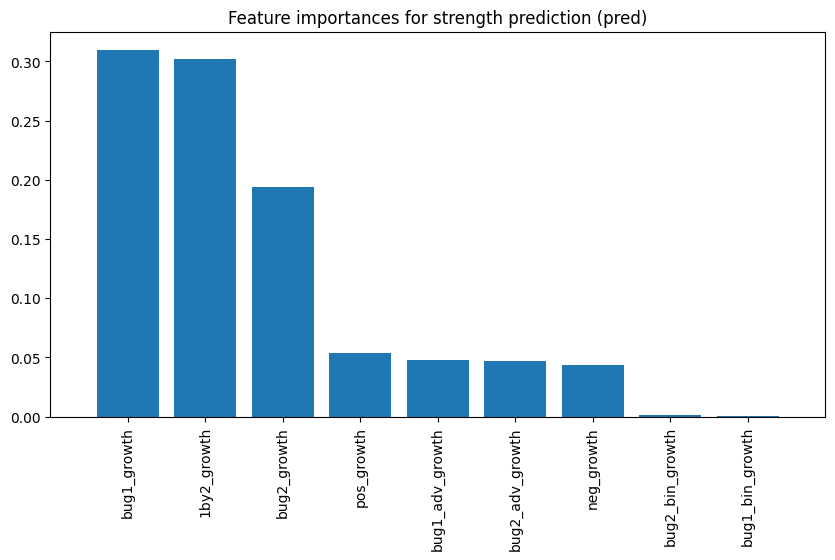

In [53]:
plot_feature_importances(
    model_strength_growth,
    X_growth,
    "Feature importances for strength prediction (pred)",
)

## Machine learning on CommScores features

### Creating feature matrices

In [195]:
commscores_ind = commscores.set_index(["media", "model1", "model2"])
commscores_ind

,,,monogr_model1,monogr_model2,cogr_model1,cogr_model2,comm_growth,mro_model1,mro_model2,cip,mip_model1,mip_model2,cmip_model1,cmip_model2,bss_model1,bss_model2,pc_model1,pc_model2,pc_comm,bit,gyd_model1,gyd_model2
media,model1,model2,,,,,,,,,,,,,,,,,,,,
Alanine,PK,PAg2,5.1835,6.3772,11.262574,0.466426,11.729,62.500,76.923,6,0,0,0,0,57.692,62.50,2.17280,0.07314,1.01460,5,-0.230290,0.187180
Arginine,PK,PAg2,13.8110,15.9920,22.415109,3.554891,25.970,62.500,76.923,8,4,1,0,0,57.692,62.50,1.62300,0.22229,0.87139,5,-0.157920,0.136380
Fructose,PK,PAg2,30.9640,38.0110,42.567212,13.656788,56.224,62.500,76.923,7,0,0,0,0,57.692,62.50,1.37470,0.35929,0.81514,5,-0.227590,0.185390
GlcNAc,PK,PAg2,30.0810,37.1350,49.170783,12.994217,62.165,62.500,76.923,12,0,0,0,0,57.692,62.50,1.63460,0.34992,0.92485,5,-0.234500,0.189960
Acetate,PK,PAg2,7.6402,14.9950,21.383336,4.454664,25.838,62.500,76.923,5,0,0,0,0,57.692,62.50,2.79880,0.29708,1.14150,5,-0.962640,0.490480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rhamnose,SF,BI,36.3190,29.7430,44.082178,5.730822,49.813,82.609,82.609,7,2,0,0,0,60.870,60.87,1.21370,0.19268,0.75403,5,0.181060,-0.221090
Sorbitol,SF,BI,36.3820,31.4000,35.042270,5.052730,40.095,82.609,82.609,8,0,0,0,0,60.870,60.87,0.96318,0.16091,0.59153,0,0.136940,-0.158660
Succinate,SF,BI,32.5560,32.5750,39.256580,4.470420,43.727,82.609,82.609,4,1,0,0,0,60.870,60.87,1.20580,0.13723,0.67137,5,-0.000584,0.000583


In [267]:
# Create subsets of X_growth, X_yield, y_sign, y_class, y_strength
feature_inds = feature_matrix[["bug1", "bug2", "carbon"]]
missing_commscores_count = 0
growth_commscores = []
yield_commscores = []
commscores_indices = []
for index, feature_ind in feature_inds.iterrows():
    media = feature_ind.carbon
    model1 = feature_ind.bug1
    model2 = feature_ind.bug2
    curr_growth_features = X_growth.loc[index, :]
    curr_yield_features = X_yield.loc[index, :]
    ind = (media, model1, model2)
    if ind in commscores_ind.index:
        curr_commscores_features = commscores_ind.loc[ind, :]
    else:
        ind = (media, model2, model1)
        if ind in commscores_ind.index:
            temp_features = commscores_ind.loc[ind, :]
            temp_features.index = temp_features.index.str.replace("model1", "model3")
            temp_features.index = temp_features.index.str.replace("model2", "model1")
            temp_features.index = temp_features.index.str.replace("model3", "model2")
            curr_commscores_features = temp_features
        else:
            missing_commscores_count += 1
            continue
    growth_commscores.append(pd.concat([curr_growth_features, curr_commscores_features]))
    yield_commscores.append(pd.concat([curr_yield_features, curr_commscores_features]))
    commscores_indices.append(index)

In [268]:
missing_commscores_count

2220

In [269]:
X_growth_commscores = pd.concat(growth_commscores, axis=1).T
X_growth_commscores.index = commscores_indices
X_yield_commscores = pd.concat(yield_commscores, axis=1).T
X_yield_commscores.index = commscores_indices
y_sign_commscores = y_sign.loc[commscores_indices]
y_class_commscores = y_class.loc[commscores_indices]
y_strength_commscores = y_strength.loc[commscores_indices]

In [270]:
X_yield_sub = X_yield.loc[commscores_indices, :]
X_growth_sub = X_growth.loc[commscores_indices, :]
y_sign_sub = y_sign.loc[commscores_indices]
y_class_sub = y_class.loc[commscores_indices]
y_strength_sub = y_strength.loc[commscores_indices]

In [271]:
assert X_growth_commscores.shape[0] == X_yield_commscores.shape[0] == y_sign_commscores.shape[0] == y_class_commscores.shape[0] == y_strength_commscores.shape[0]

### Predicting sign of interaction

In [272]:
scoring = [
    "accuracy",
    "balanced_accuracy",
    "matthews_corrcoef",
    "precision_macro",
    "recall_macro",
    "f1_macro",
]

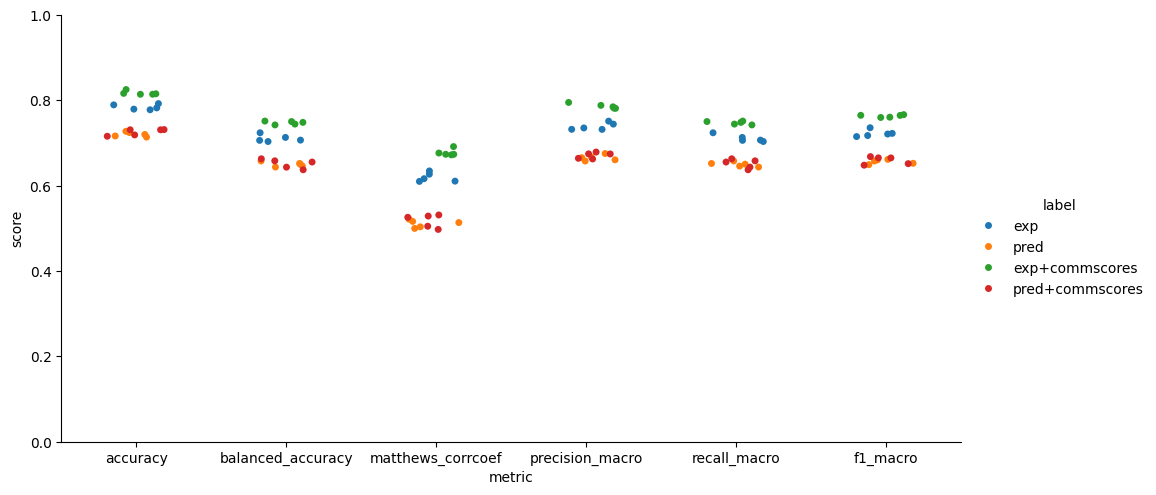

In [273]:
plot_cv([(X_yield_sub, y_sign_sub, "exp"), (X_growth_sub, y_sign_sub, "pred"), (X_yield_commscores, y_sign_commscores, "exp+commscores"), (X_growth_commscores, y_sign_commscores, "pred+commscores")], scoring)

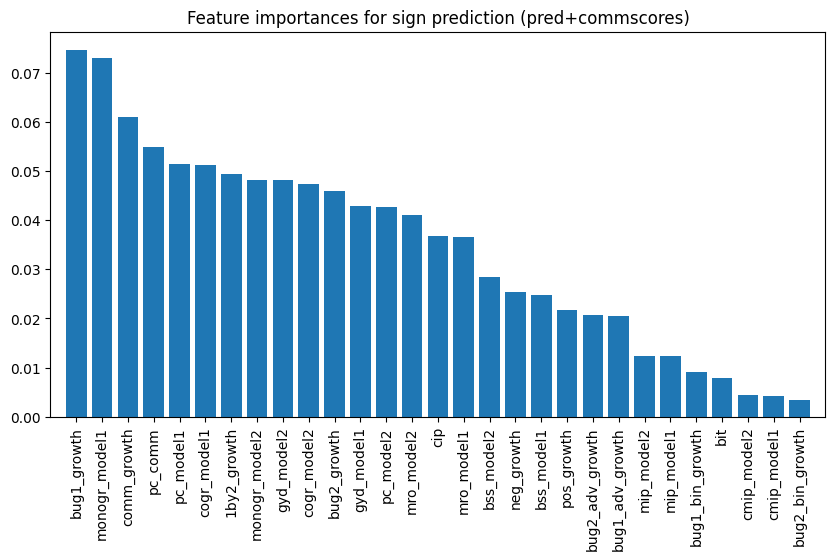

In [274]:
model_sign_growth_commscores, y_test_sign_growth_commscores, y_pred_sign_growth_commscores = perform_classification(
    X_growth_commscores, y_sign_commscores
)
plot_feature_importances(
    model_sign_growth_commscores, X_growth_commscores, "Feature importances for sign prediction (pred+commscores)"
)

### Predicting interaction class

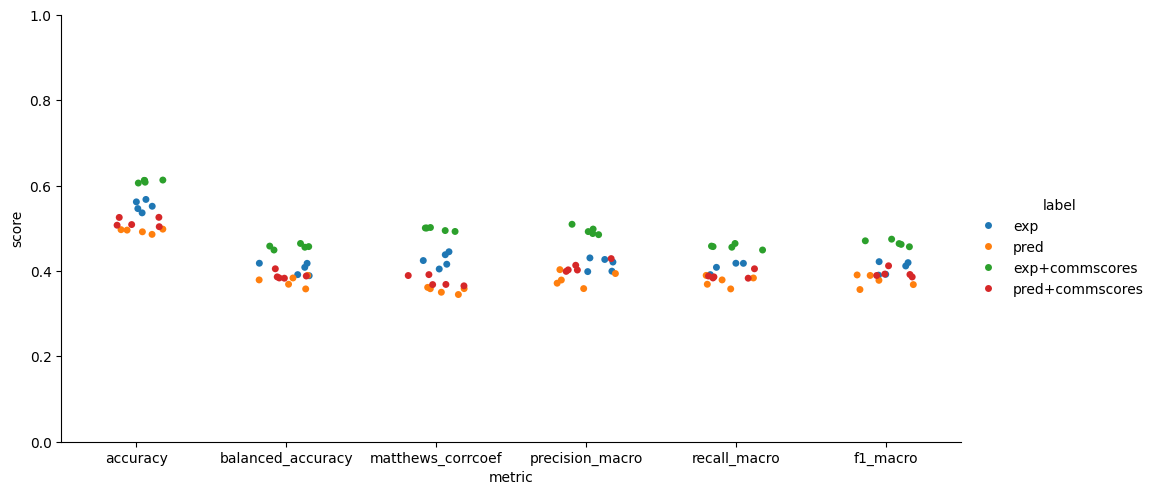

In [275]:
plot_cv([(X_yield_sub, y_class_sub, "exp"), (X_growth_sub, y_class_sub, "pred"), (X_yield_commscores, y_class_commscores, "exp+commscores"), (X_growth_commscores, y_class_commscores, "pred+commscores")], scoring)

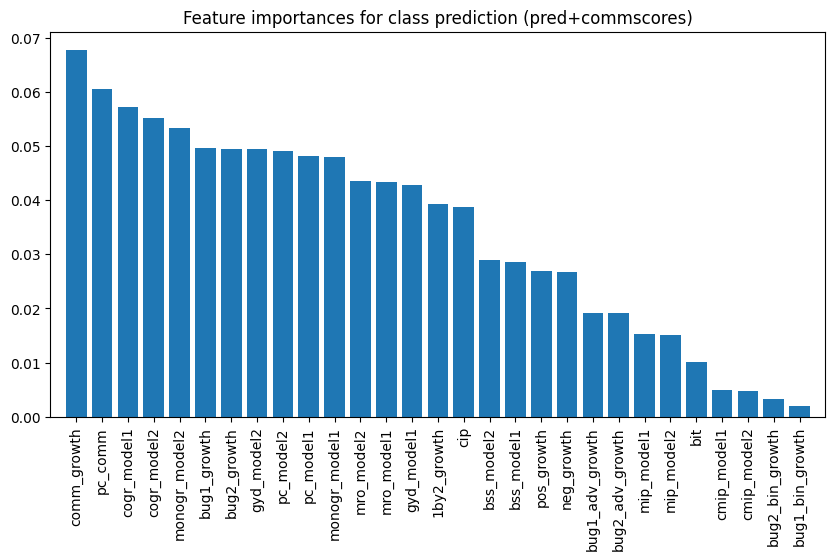

In [276]:
model_class_growth_commscores, y_test_class_growth_commscores, y_pred_class_growth_commscores = perform_classification(
    X_growth_commscores, y_class_commscores
)
plot_feature_importances(
    model_class_growth_commscores, X_growth_commscores, "Feature importances for class prediction (pred+commscores)"
)

### Predicting interaction strength

In [277]:
scoring = ["neg_mean_absolute_error", "neg_mean_squared_error", "r2"]

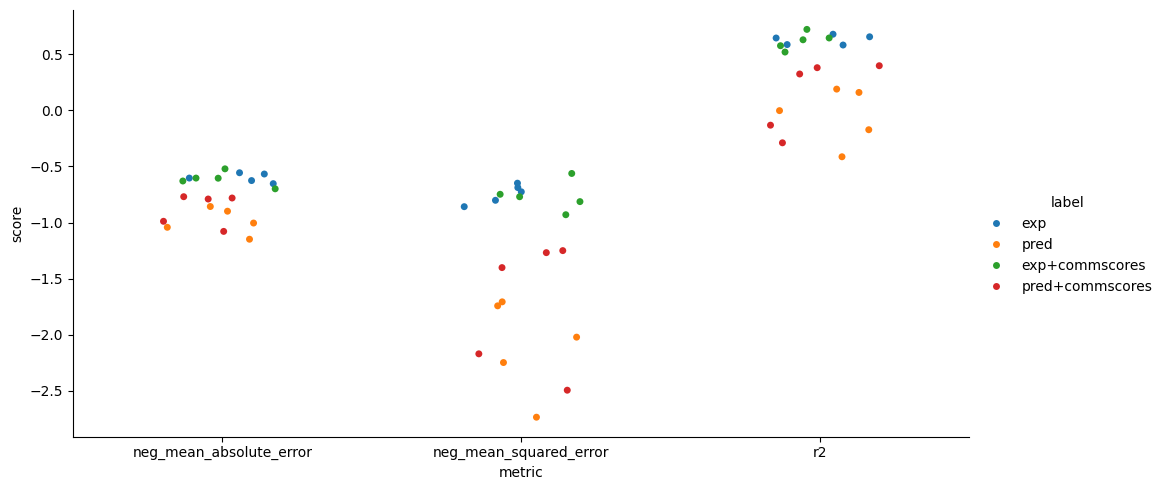

In [278]:
plot_cv([(X_yield_sub, y_strength_sub, "exp"), (X_growth_sub, y_strength_sub, "pred"), (X_yield_commscores, y_strength_commscores, "exp+commscores"), (X_growth_commscores, y_strength_commscores, "pred+commscores")], scoring, ctype="regression")

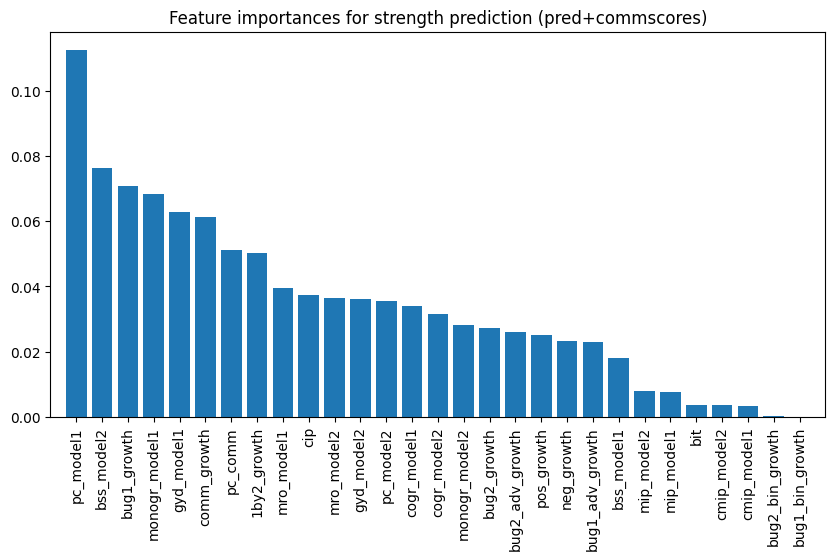

In [279]:
model_strength_growth_commscores, y_test_strength_growth_commscores, y_pred_strength_growth_commscores = perform_classification(
    X_growth_commscores, y_strength_commscores, ctype="regression"
)
plot_feature_importances(
    model_strength_growth_commscores, X_growth_commscores, "Feature importances for strength prediction (pred+commscores)"
)

## Carbon-source specific ML models and results

In [280]:
scoring_str = "accuracy"

In [281]:
def plot_cv_per_csource(Xylm_iter, scoring_str, ctype="classification"):
    cv_results_list = []
    for X, y, label, media in Xylm_iter:
        cv_results = perform_cv(X, y, scoring_str, ctype)
        cv_results["label"] = label
        cv_results["media"] = media
        cv_results_list.append(cv_results)
    test_combined = pd.concat(cv_results_list)
    plot_data = test_combined
    sns.catplot(
        data=plot_data,
        x="media",
        y="score",
        # kind="strip",
        kind="box",
        aspect=3,
        hue="label",
        # jitter=0.2,
    )
    if ctype == "classification":
        plt.ylim(0, 1)

### Predicting sign of interaction

In [282]:
media_indices_dict = feature_matrix.reset_index().groupby('carbon')["index"].apply(list).to_dict()

In [283]:
Xylm_list = []
y_posneg = y_sign_commscores
for media, media_indices in media_indices_dict.items():
    selected_indices = [i for i in media_indices if i in commscores_indices]
    n_classes = y_posneg.loc[selected_indices].nunique()
    min_class_count = y_posneg.loc[selected_indices].value_counts().min()
    if (min_class_count <= 5) or (n_classes < 2):
        print(f"Skipping {media} due to class imbalance")
        continue
    Xylm_list.append((X_yield.loc[selected_indices, :], y_posneg.loc[selected_indices], "exp", media))
    Xylm_list.append((X_growth.loc[selected_indices, :], y_posneg.loc[selected_indices], "pred", media))
    Xylm_list.append((X_yield_commscores.loc[selected_indices, :], y_posneg.loc[selected_indices], "exp+commscores", media))
    Xylm_list.append((X_growth_commscores.loc[selected_indices, :], y_posneg.loc[selected_indices], "pred+commscores", media))

Skipping Arabinogalactan due to class imbalance
Skipping Melezitose due to class imbalance
Skipping Water due to class imbalance
Skipping Xylose due to class imbalance


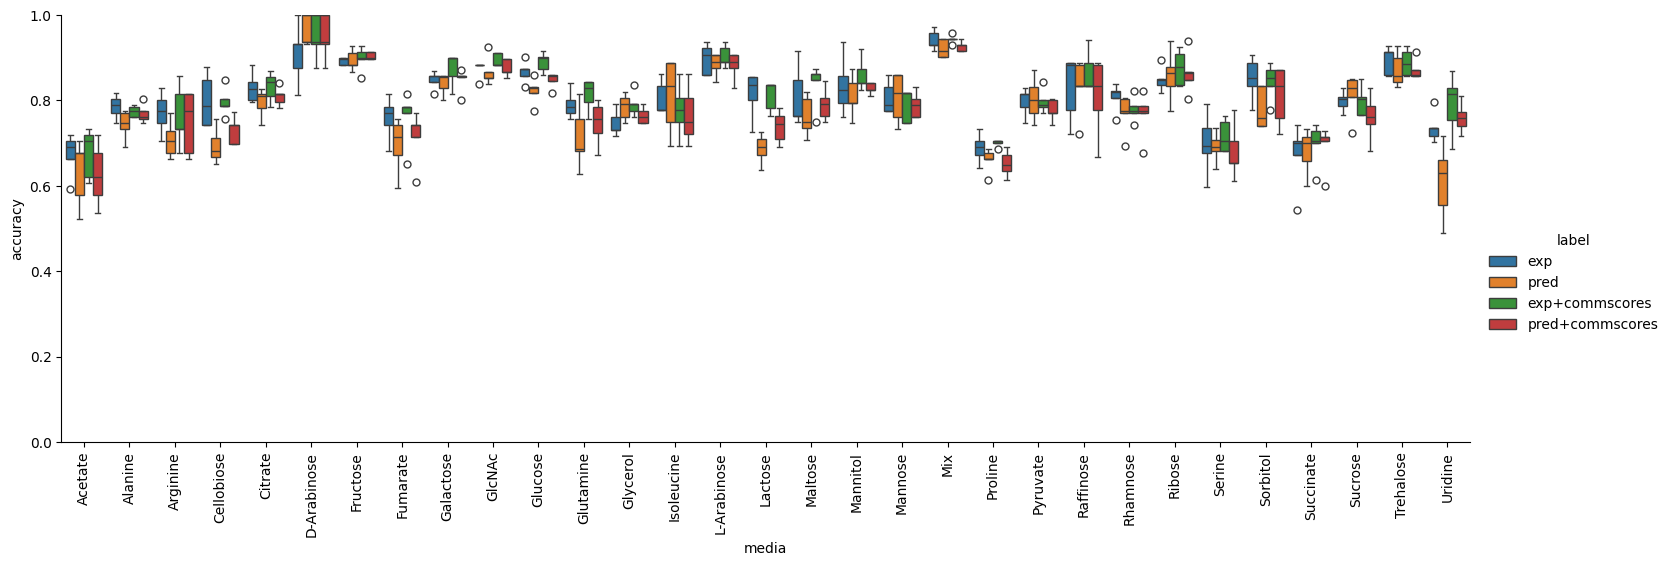

In [284]:
plot_cv_per_csource(Xylm_list, scoring_str)
plt.ylabel(scoring_str);
plt.xticks(rotation=90);

### Predicting interaction class

In [285]:
Xylm_list = []
for media, media_indices in media_indices_dict.items():
    selected_indices = [i for i in media_indices if i in commscores_indices]
    n_classes = y_class.loc[selected_indices].nunique()
    min_class_count = y_class.loc[selected_indices].value_counts().min()
    if (min_class_count <= 5) or (n_classes < 2):
        print(f"Skipping {media} due to class imbalance")
        continue
    Xylm_list.append((X_yield.loc[selected_indices, :], y_class.loc[selected_indices], "exp", media))
    Xylm_list.append((X_growth.loc[selected_indices, :], y_class.loc[selected_indices], "pred", media))
    Xylm_list.append((X_yield_commscores.loc[selected_indices, :], y_class.loc[selected_indices], "exp+commscores", media))
    Xylm_list.append((X_growth_commscores.loc[selected_indices, :], y_class.loc[selected_indices], "pred+commscores", media))

Skipping Alanine due to class imbalance
Skipping Arabinogalactan due to class imbalance
Skipping Cellobiose due to class imbalance
Skipping Fructose due to class imbalance
Skipping Galactose due to class imbalance
Skipping Glucose due to class imbalance
Skipping Isoleucine due to class imbalance
Skipping L-Arabinose due to class imbalance
Skipping Lactose due to class imbalance
Skipping Maltose due to class imbalance
Skipping Melezitose due to class imbalance
Skipping Mix due to class imbalance
Skipping Pyruvate due to class imbalance
Skipping Raffinose due to class imbalance
Skipping Serine due to class imbalance
Skipping Sucrose due to class imbalance
Skipping Trehalose due to class imbalance
Skipping Uridine due to class imbalance
Skipping Water due to class imbalance
Skipping Xylose due to class imbalance


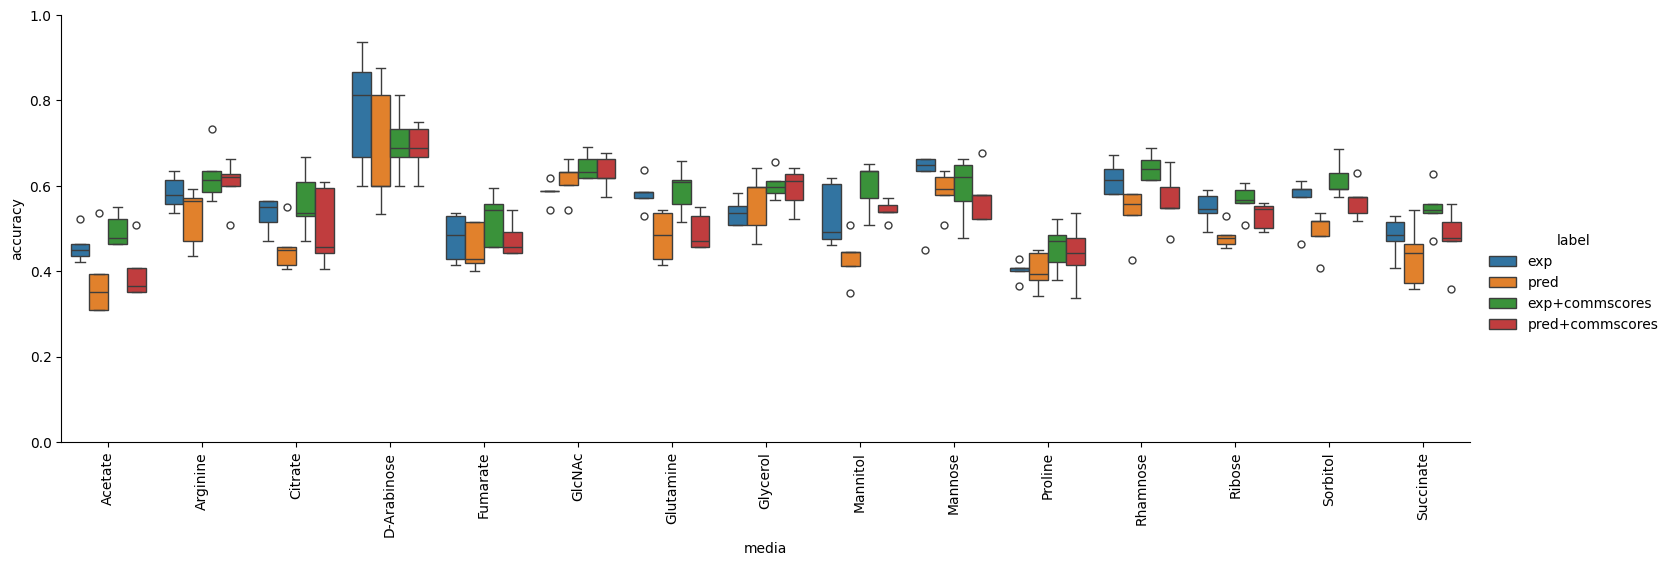

In [286]:
plot_cv_per_csource(Xylm_list, scoring_str)
plt.ylabel(scoring_str);
plt.xticks(rotation=90);